In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score, RepeatedKFold

In [2]:
# Preparar el conjunto de datos
def get_dataset():
    np.random.seed(420)
    X, y = make_regression(n_samples=100, n_features=1, tail_strength=0.9, effective_rank=1, n_informative=1, noise=3, bias=50)

    # Agregar algunos valores atípicos artificiales
    np.random.seed()
    for i in range(10):
        factor = random.randint(2, 4)
        if random.random() > 0.5:
            X[i] += factor * np.std(X)
        else:
            X[i] -= factor * np.std(X)
    
    return X, y

(100, 1) (100,)


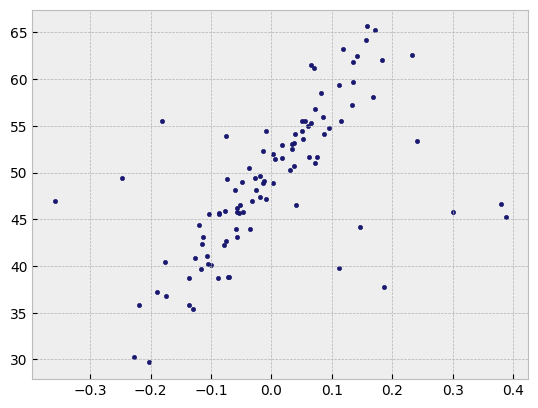

In [3]:
# Cargar conjunto de datos
X, y = get_dataset()

# Resumir la forma
print(X.shape, y.shape)

# Gráfica de dispersión de entrada contra salida
with plt.style.context('bmh'):
     plt.scatter(X, y, color='midnightblue', marker='.')

In [4]:
# Evaluar un modelo
def evaluate_model(X, y, model):
    # Definir el método de evaluación del modelo
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    
    # Evaluar el modelo
    results = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    
    # Forzar las puntuaciones a ser positivas
    return np.absolute(results)

In [5]:
# Traza el conjunto de datos y la línea de mejor ajuste del modelo
def plot_best_fit(X, y, model):
    # Ajustar el modelo en todos los datos
    model.fit(X, y)
    
    # Trazar el conjunto de datos
    plt.style.use('bmh')
    plt.scatter(X, y, color='black', marker='.')
    
    # Trazar la línea de mejor ajuste
    x_axis = np.arange(X.min(), X.max(), 0.01)
    y_axis = model.predict(x_axis.reshape((len(x_axis), 1)))
    plt.plot(x_axis, y_axis, color='g')
    
    # Mostrar la gráfica
    plt.title(type(model).__name__)
    plt.show()

## Regresión Lineal

La regresión lineal es una técnica estadística utilizada para modelar la relación entre una variable independiente y una variable dependiente, ajustando la relación a una línea, plano o hiperplano.
Si los datos contienen valores atípicos, la línea puede resultar sesgada, lo que resulta en un peor rendimiento predictivo.

Promedio MAE: 4.885 (1.408)


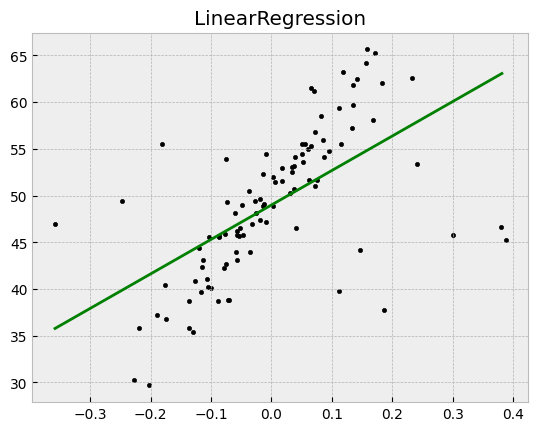

In [6]:
from sklearn.linear_model import LinearRegression
# Definir el modelo
model = LinearRegression()

# Evaluar el modelo
results = evaluate_model(X, y, model)

print("Promedio MAE: %.3f (%.3f)" % (np.mean(results), np.std(results)))

# Trazar la línea de mejor ajuste
plot_best_fit(X, y, model)

## Regresión Robusta

La regresión robusta se refiere a un conjunto de algoritmos utilizados para modelar la relación entre las variables en presencia de valores atípicos.

A diferencia de la regresión ordinaria, la regresión robusta busca minimizar el impacto de los valores atípicos en la estimación de los parámetros del modelo, proporcionando así una estimación más resistente y confiable.

### Regresión Huber

La regresión Huber es un tipo de regresión robusta que es consciente de la posibilidad de que existan valores atípicos en un conjunto de datos y les asigna menos peso que a los valores normales del conjunto de datos.

Esta regresión utiliza una función de pérdida cuadrática para valores pequeños de error y lineal para valores grandes de error. Al ajustar un modelo de regresión Huber, se busca minimizar la suma de las funciones de pérdida Huber para todos los puntos de datos. Esto se puede lograr utilizando métodos numéricos de optimización, como el descenso de gradiente o el algoritmo iterativo iteratively reweighted least squares (IRLS).

Podemos usar la regresión de Huber a través de la clase de Huber-Regressor en el scikit-learn. La función de pérdida de Huber tiene la ventaja de no estar muy influenciada por los valores atípicos y no ignorar por completo su efecto.

Promedio MAE: 4.313 (1.849)


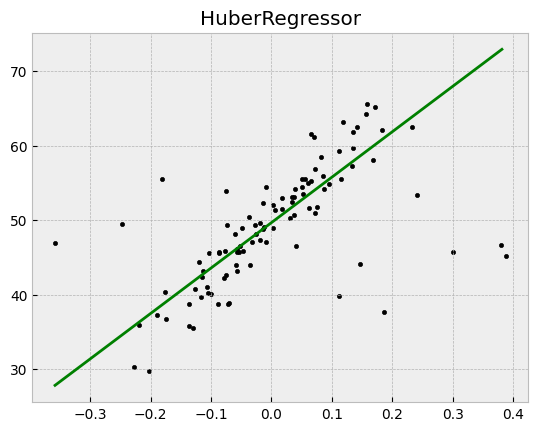

In [7]:
from sklearn.linear_model import HuberRegressor
# Definir el modelo
modelo = HuberRegressor(epsilon=1.35, max_iter=100, alpha=0.0001, warm_start=False, fit_intercept=True, tol=1e-05)

"""
epsilon controla que valores se calsifican como atipicos 
max_iter establece el numero máximo de iteraciones 
alpha controla la regularización o penalización aplicada a los coeficientes 
del modelo de regresión, evitando el overfitting (Mayor → menos overfitting).
... ver referencias
"""

# Evaluar el modelo
resultados = evaluate_model(X, y, modelo)

print("Promedio MAE: %.3f (%.3f)" % (np.mean(resultados), np.std(resultados)))

# Trazar la línea de mejor ajuste
plot_best_fit(X, y, modelo)

### Regresión RANSAC

La regresión RANSAC (Random Sample Consensus) seleccionando un subconjunto aleatorio de puntos (inliers) que se ajustan bien al modelo propuesto y utilizandolo a para estimar los parámetros del modelo.

El algoritmo RANSAC selecciona aleatoriamente un número mínimo de puntos requeridos para ajustar el modelo. Estos puntos se denominan inliers con los que estima los parámetros del modelo, luego evalua el modelo dentro de un umbral de error predefinido. 

Luego, itera hasta encontrar el modelo que tiene el mayor número de inliers o que cumple con un criterio de convergencia predefinido. Podemos usar la regresión de RANSAC a través de la clase de RANSACRegressor de scikit-learn.

Promedio MAE: 4.464 (2.119)


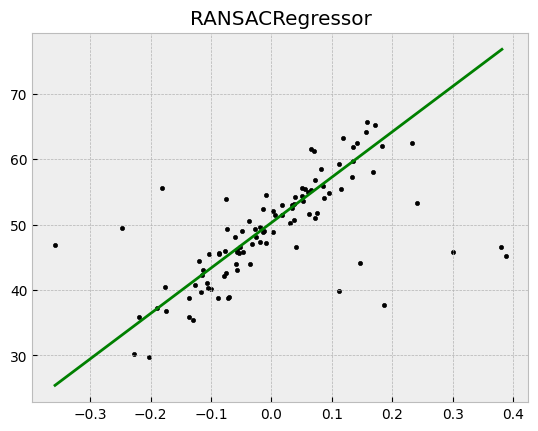

In [8]:
from sklearn.linear_model import RANSACRegressor
# Definir el modelo
modelo = RANSACRegressor()

# Evaluar el modelo
resultados = evaluate_model(X, y, modelo)

print("Promedio MAE: %.3f (%.3f)" % (np.mean(resultados), np.std(resultados)))

# Trazar la línea de mejor ajuste
plot_best_fit(X, y, modelo)

### Regresión TheilSenRegressor

La regresión TheilSen es un método de regresión robusto que estima los parámetros de un modelo de regresión lineal utilizando la técnica de la mediana de pendientes. A diferencia de la regresión lineal ordinaria (OLS), que utiliza el método de mínimos cuadrados para estimar los parámetros, TheilSenRegressor estima los coeficientes de la recta de regresión utilizando la mediana de las pendientes entre todos los pares de puntos en el conjunto de datos.

La regresión TheilSenRegressor es robusta en presencia de valores atípicos, ya que utiliza la mediana de las pendientes, que es menos sensible a los valores extremos que el método de mínimos cuadrados de la regresión OLS. Nuevamente, podemos usar la regresión de TheilSen a través de la clase de TheilSenRegressor de scikit-learn.

Promedio MAE: 4.296 (1.929)


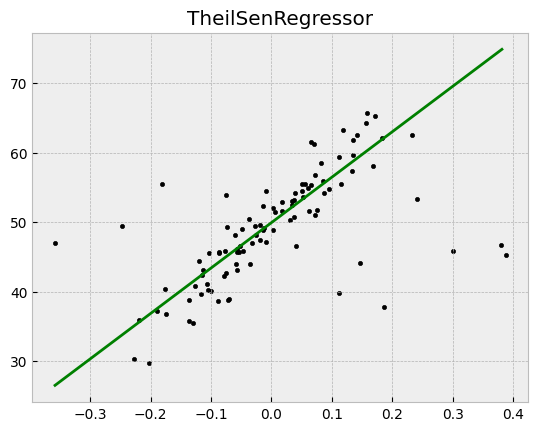

In [9]:
from sklearn.linear_model import TheilSenRegressor 
# Definir el modelo
modelo = TheilSenRegressor()

# Evaluar el modelo
resultados = evaluate_model(X, y, modelo)

print("Promedio MAE: %.3f (%.3f)" % (np.mean(resultados), np.std(resultados)))

# Trazar la línea de mejor ajuste
plot_best_fit(X, y, modelo)

In [10]:
def plot_best_fit2(X, y, xaxis, modelo):
    # Ajustar el modelo en todos los datos
    modelo.fit(X, y)
    
    # Calcular las salidas para la cuadrícula a través del dominio
    yaxis = modelo.predict(xaxis.reshape((len(xaxis), 1)))
    
    # trazar la línea de mejor ajuste
    plt.plot(xaxis, yaxis, label=type(modelo).__name__)

In [11]:
# Diccionario de nombres de modelos y objetos modelo
def get_models():
    modelos = []
    modelos.append(LinearRegression())
    modelos.append(HuberRegressor())
    modelos.append(RANSACRegressor())
    modelos.append(TheilSenRegressor())
    return modelos

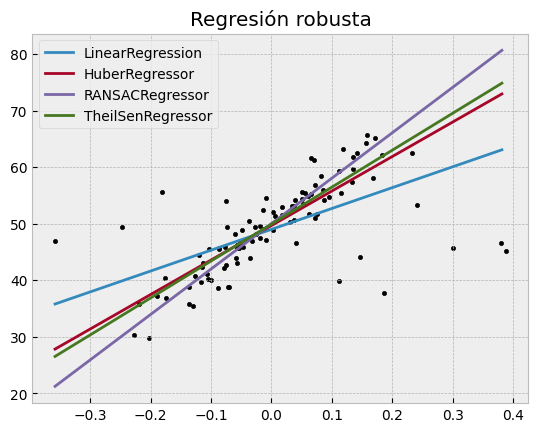

In [12]:
# Definir una cuadrícula uniforme a través del dominio de entrada
xaxis = np.arange(X.min(), X.max(), 0.01)

for modelo in get_models():
    # trazar la línea de mejor ajuste
    plot_best_fit2(X, y, xaxis, modelo)

# Trazar el conjunto de datos
plt.scatter(X, y, color='black', marker='.')

# Mostrar la gráfica
plt.title('Regresión robusta')
plt.legend()
plt.show()

### Ejemplo práctico

In [13]:
import pandas as pd
url = 'https://raw.githubusercontent.com/MaxWell-73/Data-Analysis/main/Folder_data/FIFA23DB/CLEAN_FIFA23_official_data.csv'
fifa23 = pd.read_csv(url)
fifa23.head(5)

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Position,Joined,Loaned From,Contract Valid Until,Height(cm.),Weight(lbs.),Release Clause(£),Kit Number,Best Overall Rating,Year_Joined
0,0,209658,L. Goretzka,27,https://cdn.sofifa.net/players/209/658/23_60.png,Germany,https://cdn.sofifa.net/flags/de.png,87,88,FC Bayern München,...,SUB,2018-07-01,NaN,2026.0,189.0,180.810,157000000.0,8.0,0.0,2018
1,1,212198,Bruno Fernandes,27,https://cdn.sofifa.net/players/212/198/23_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,86,87,Manchester United,...,LCM,2020-01-30,NaN,2026.0,179.0,152.145,155000000.0,8.0,0.0,2020
2,2,224334,M. Acuña,30,https://cdn.sofifa.net/players/224/334/23_60.png,Argentina,https://cdn.sofifa.net/flags/ar.png,85,85,Sevilla FC,...,LB,2020-09-14,NaN,2024.0,172.0,152.145,97700000.0,19.0,0.0,2020
3,3,192985,K. De Bruyne,31,https://cdn.sofifa.net/players/192/985/23_60.png,Belgium,https://cdn.sofifa.net/flags/be.png,91,91,Manchester City,...,RCM,2015-08-30,NaN,2025.0,181.0,154.350,198900000.0,17.0,0.0,2015
4,4,224232,N. Barella,25,https://cdn.sofifa.net/players/224/232/23_60.png,Italy,https://cdn.sofifa.net/flags/it.png,86,89,Inter,...,RCM,2020-09-01,NaN,2026.0,172.0,149.940,154400000.0,23.0,0.0,2020


In [14]:
fifa23.columns

Index(['Unnamed: 0', 'ID', 'Name', 'Age', 'Photo', 'Nationality', 'Flag',
       'Overall', 'Potential', 'Club', 'Club Logo', 'Value(£)', 'Wage(£)',
       'Special', 'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', 'Position',
       'Joined', 'Loaned From', 'Contract Valid Until', 'Height(cm.)',
       'Weight(lbs.)', 'Release Clause(£)', 'Kit Number',
       'Best Overall Rating', 'Year_Joined'],
      dtype='object')

In [15]:
x1 = fifa23['Overall'].to_numpy()
y1 = fifa23['Potential'].to_numpy()
N = 1000

In [16]:
x1 = x1[:N].reshape((N, 1))
y1 = y1[:N].reshape(-1, 1)

C:\Users\Angel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Angel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


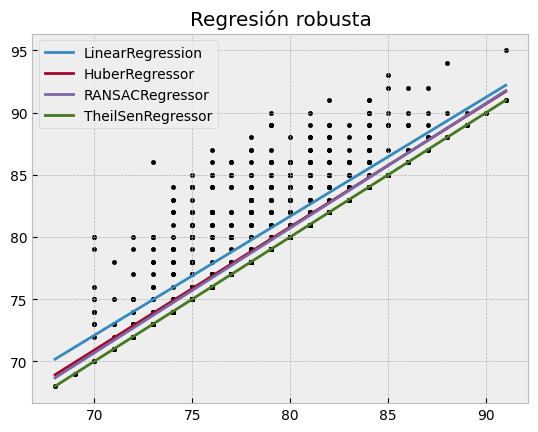

In [17]:
# Definir una cuadrícula uniforme a través del dominio de entrada
xaxis = np.arange(x1.min(), x1.max(), 0.01)
results = []
for modelo in get_models():
    # trazar la línea de mejor ajuste
    plot_best_fit2(x1, y1, xaxis, modelo)
        # Calcular la pendiente de la línea de mejor ajuste
    if hasattr(modelo, 'coef_'):
        slope = modelo.coef_[0]
    elif hasattr(modelo, 'estimator_'):
        slope = modelo.estimator_.coef_[0]
    else:
        slope = None
    
    if slope is not None:
        slope = np.round(slope, 3)
        results.append({'Modelo': type(modelo).__name__, 'Pendiente': slope})

# Trazar el conjunto de datos
plt.scatter(x1, y1, color='black', marker='.')

# Mostrar la gráfica
plt.title('Regresión robusta')
plt.legend()
plt.show()


In [18]:
from IPython.display import display, HTML
# Convertir los resultados a un DataFrame
df = pd.DataFrame(results)

# Mostrar la tabla HTML
display(HTML(df.to_html(index=False)))

Modelo,Pendiente
LinearRegression,[0.958]
HuberRegressor,0.991
RANSACRegressor,[1.004]
TheilSenRegressor,1.0


### Referencias

https://topbigdata.es/robusta-regresion-para-el-aprendizaje-de-la-maquina-en-python/
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.HuberRegressor.html
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RANSACRegressor.html
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.TheilSenRegressor.html